In [ ]:
# Get helper_function.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper function we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir



--2021-09-13 07:58:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-09-13 07:58:05 (89.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## **Model 2: Feature Extraction transfer learning with 10% of data and data augmentation**

In [ ]:
import tensorflow as tf

# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

# Create training / testing dir
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2021-09-13 08:01:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 74.125.70.128, 74.125.201.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   174MB/s    in 0.9s    

2021-09-13 08:01:18 (174 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# Create data loader
# Setup data inputs

IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build a data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  #preprocessing.Rescale(rescale=1./255)                                
],name= "data_augmentation")

# Setup input shape
input_shape= (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="Global_average_pooling")(x)
outputs=tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Create model
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Setup checkpoint callback
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weight only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         save_freq="epoch",
                                                         verbose=1,
                                                         save_best_only=False)

# Fit the model
initial_epochs=5
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning","10_percent_data_aug"),checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210913-081439
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 55s 935ms/step - loss: 1.9642 - accuracy: 0.3547 - val_loss: 1.5282 - val_accuracy: 0.6168

Epoch 00001: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 18s 738ms/step - loss: 1.3599 - accuracy: 0.6560 - val_loss: 1.1122 - val_accuracy: 0.7204

Epoch 00002: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 17s 698ms/step - loss: 1.0609 - accuracy: 0.7387 - val_loss: 0.8927 - val_accuracy: 0.7747

Epoch 00003: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 13s 510ms/step - loss: 0.9002 - accuracy: 0.7720 - val_loss: 0.7885 - val_accuracy: 0.8043

Epoch 00004: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 15s 633ms/step - loss: 0.7877 - accuracy: 0.7947 - val_loss

In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 11s 134ms/step - loss: 0.7033 - accuracy: 0.8124


[0.7032979726791382, 0.8123999834060669]

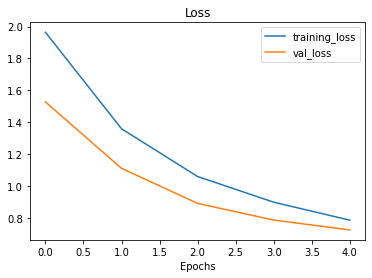

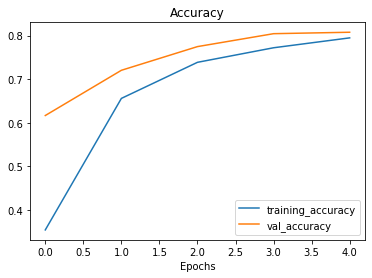

In [ ]:
# Plot the loss curves
plot_loss_curves(history_2)

In [ ]:
# Loadin saved model weights and evaluate the model
model_2.load_weights(checkpoint_path)
load_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 128ms/step - loss: 0.7033 - accuracy: 0.8124


## **Model 3: Fine-tuning an existing model on 10% of the data**

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# How many layers are trainable in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# Check with layers are trainable in base model
for num, layer in enumerate(base_model.layers):
  print(num, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

In [ ]:
# Unfree the top 10 layers in base model
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Check which layer are tuneable (trainable)
for num, layer in enumerate(base_model.layers):
  print(num, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
print(len(model_2.trainable_variables))

12


We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

In [ ]:
history_2.epoch[-1]

4

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_2.epoch[-1],
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210913-083230
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 26s 729ms/step - loss: 0.7225 - accuracy: 0.7973 - val_loss: 0.6083 - val_accuracy: 0.8076
Epoch 6/10
24/24 [==============================] - 13s 514ms/step - loss: 0.5780 - accuracy: 0.8400 - val_loss: 0.5522 - val_accuracy: 0.8141
Epoch 7/10
24/24 [==============================] - 14s 549ms/step - loss: 0.5181 - accuracy: 0.8400 - val_loss: 0.5335 - val_accuracy: 0.8174
Epoch 8/10
24/24 [==============================] - 15s 624ms/step - loss: 0.4619 - accuracy: 0.8693 - val_loss: 0.5045 - val_accuracy: 0.8289
Epoch 9/10
24/24 [==============================] - 14s 554ms/step - loss: 0.4079 - accuracy: 0.8813 - val_loss: 0.5486 - val_accuracy: 0.8174
Epoch 10/10
24/24 [==============================] - 12s 469ms/step - loss: 0.3833 - accuracy: 0.8880 - val_loss: 0.5080 - val_accuracy: 0.8306


In [ ]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 128ms/step - loss: 0.4963 - accuracy: 0.8344


In [ ]:
import matplotlib.pyplot as plt

def compare_history(original_history, new_history, initial_epochs=5):
  # Get the original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  print(len(acc))
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  print(len(total_acc))
  
  # Make plot
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1],
           plt.ylim(), label="Start Fine Tuning")
  plt.legend("lower right")
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.show();

5
11


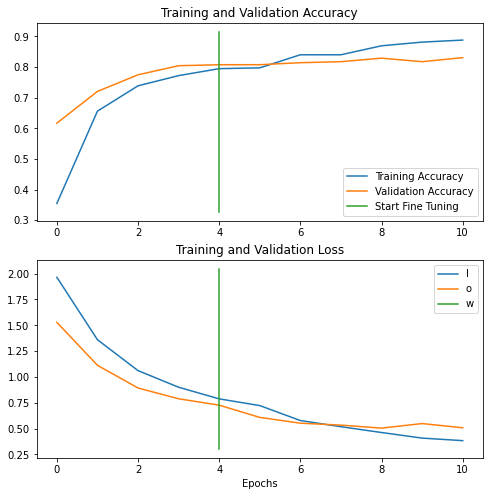

In [ ]:
compare_history(history_2,history_fine_10_percent_data_aug, initial_epochs=5)

## **Model 4: Fine-tuning a existing model all of the data**

In [ ]:
# Download and unzip 10 classes of data with all images
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
# unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# How many images we're working on
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.

In [ ]:
# Setup data inputs ( Data Loader )
import tensorflow as tf

train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_classes_full

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

In [ ]:
# Evaluate model 2
model_2.evaluate(test_data)

79/79 [==============================] - 11s 128ms/step - loss: 0.4963 - accuracy: 0.8344


[0.4962846338748932, 0.8343999981880188]

In [ ]:
# Same values as results fine_tune_10_percent
results_fine_tune_10_percent

[0.49628475308418274, 0.8343999981880188]

And the results should be same as results_10_percent_data_aug.

In [ ]:
# Load model from checkpoint
model_2.load_weights(checkpoint_path)

In [ ]:
# Check to see if the above two results are same
model_2.evaluate(test_data)

79/79 [==============================] - 11s 127ms/step - loss: 0.7033 - accuracy: 0.8124


[0.7032981514930725, 0.8123999834060669]

In [ ]:
results_10_percent_data_aug

[0.7032979726791382, 0.8123999834060669]

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [ ]:
# Check which layers are tuneable in the whole model
for num, layer in enumerate(model_2.layers):
  print(num, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 Global_average_pooling True
4 output_layer True


In [ ]:
# Check on base model
for num, layer in enumerate(base_model.layers):
  print(num, layer.name, layer.trainable)

In [ ]:
# COmpile the model_2
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5 

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_2.epoch[-1],
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210913-090050
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 69s 264ms/step - loss: 0.6927 - accuracy: 0.7815 - val_loss: 0.3396 - val_accuracy: 0.9013
Epoch 6/10
235/235 [==============================] - 79s 333ms/step - loss: 0.4866 - accuracy: 0.8428 - val_loss: 0.4183 - val_accuracy: 0.8799
Epoch 7/10
235/235 [==============================] - 75s 315ms/step - loss: 0.3974 - accuracy: 0.8748 - val_loss: 0.3145 - val_accuracy: 0.9046
Epoch 8/10
235/235 [==============================] - 68s 289ms/step - loss: 0.3344 - accuracy: 0.8895 - val_loss: 0.3052 - val_accuracy: 0.9112
Epoch 9/10
235/235 [==============================] - 61s 257ms/step - loss: 0.2953 - accuracy: 0.9031 - val_loss: 0.3840 - val_accuracy: 0.8964
Epoch 10/10
235/235 [==============================] - 64s 270ms/step - loss: 0.2535 - accuracy: 0.9148 - val_loss: 0.3760 - val_accuracy: 0.8799


In [ ]:
results_fine_tune_full_data =  model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 11s 128ms/step - loss: 0.3677 - accuracy: 0.8824


[0.36766207218170166, 0.8823999762535095]

Nice! It looks like fine-tuning with all of the data has given our model a boost, how do the training curves look?

5
11


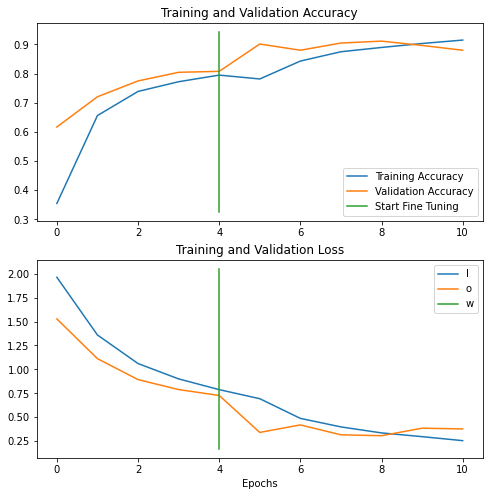

In [ ]:
# How did fine-tuning go with more data
compare_history(original_history=history_2,
                new_history=history_fine_10_classes_full,
                initial_epochs=5)

In [ ]:
# View on tensorboard
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot

2021-09-13 09:11:32.728387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-13 09:11:32.735924: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-13 09:11:32.736490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/fvCQIWMyQwKVO2JPVZMSrQ/

[2021-09-13T09:11:32] Started scanning logdir.
[2021-09-13T09:11:35] Total uploaded: 102 scalars, 0 tensors, 3 binary objects (2.4 MB)
[2021-09-13T09:11:35] Done scanning logdir.


Done. View your TensorBoard at https://tensorboa

# **🛠 05. Transfer Learning in TensorFlow Part 2: Fine-tuning Exercise Solutions Questions**

1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

2. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

## Getting data and setting things up (10% data)

In [ ]:
# Import required things
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.callbacks as callbacks
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
# getting the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip data
unzip_data("10_food_classes_10_percent.zip")

--2021-09-13 09:14:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   165MB/s    in 1.0s    

2021-09-13 09:14:17 (165 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# How many images in each other
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
# Getting data loader
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

IMG_SIZE=(224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

In [ ]:
# Create checkpoint callback to save model
checkpoint_path = "food_vision_check_point/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         verbose=1)

In [ ]:
# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
# Taking inputs
inputs = tf.keras.layers.Input(shape=(224, 224, 3),name="input_layer")
x = base_model(inputs)
# Global Average Pooling Layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Creating outputs
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
# Putting the model together
model = tf.keras.Model(inputs, outputs)
# Show summary

model.summary()



Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Compilling the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Fitting the model with 5 epochs and save weights
initial_epochs = 5

history_1 = model.fit(train_data,
                      epochs=initial_epochs,
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      callbacks=[checkpoint_callback])

Epoch 1/5
24/24 [==============================] - 14s 586ms/step - loss: 0.0111 - accuracy: 0.9987 - val_loss: 0.4533 - val_accuracy: 0.8608

Epoch 00001: saving model to food_vision_check_point/
Epoch 2/5
24/24 [==============================] - 14s 580ms/step - loss: 0.0127 - accuracy: 0.9973 - val_loss: 0.4548 - val_accuracy: 0.8628

Epoch 00002: saving model to food_vision_check_point/
Epoch 3/5
24/24 [==============================] - 14s 583ms/step - loss: 0.0193 - accuracy: 0.9973 - val_loss: 0.5126 - val_accuracy: 0.8500

Epoch 00003: saving model to food_vision_check_point/
Epoch 4/5
24/24 [==============================] - 14s 583ms/step - loss: 0.0137 - accuracy: 0.9987 - val_loss: 0.4887 - val_accuracy: 0.8588

Epoch 00004: saving model to food_vision_check_point/
Epoch 5/5
24/24 [==============================] - 14s 577ms/step - loss: 0.0172 - accuracy: 0.9933 - val_loss: 0.5151 - val_accuracy: 0.8580

Epoch 00005: saving model to food_vision_check_point/


## Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [ ]:
for num, layer in enumerate(base_model.layers):
  print(num, layer.name, layer.trainable)

In [ ]:
base_model.trainable = True
# Fine tune the last 20 layers
for layer in base_model.layers[:-20]:
  layer.trainable=False

In [ ]:
for num, layer in enumerate(base_model.layers):
  print(num, layer.name, layer.trainable)

0 input_7 False
1 rescaling_5 False
2 normalization_5 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# Recompiling
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [ ]:
# Fit the model
fine_tune_epochs = initial_epochs + 5
history_2 = model.fit(train_data,
                      epochs=fine_tune_epochs,
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      initial_epoch=history_1.epoch[-1])

Epoch 5/10
24/24 [==============================] - 22s 657ms/step - loss: 0.7207 - accuracy: 0.7893 - val_loss: 0.7284 - val_accuracy: 0.7764
Epoch 6/10
24/24 [==============================] - 14s 583ms/step - loss: 0.1887 - accuracy: 0.9507 - val_loss: 0.6626 - val_accuracy: 0.7952
Epoch 7/10
24/24 [==============================] - 14s 587ms/step - loss: 0.0698 - accuracy: 0.9907 - val_loss: 0.5047 - val_accuracy: 0.8436
Epoch 8/10
24/24 [==============================] - 14s 580ms/step - loss: 0.0386 - accuracy: 0.9960 - val_loss: 0.4440 - val_accuracy: 0.8560
Epoch 9/10
24/24 [==============================] - 14s 574ms/step - loss: 0.0202 - accuracy: 1.0000 - val_loss: 0.4357 - val_accuracy: 0.8620
Epoch 10/10
24/24 [==============================] - 14s 580ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.4436 - val_accuracy: 0.8672


In [ ]:
# eValuate the model
results_20_fine_tune = model.evaluate(test_data)
results_20_fine_tune

79/79 [==============================] - 11s 127ms/step - loss: 0.4436 - accuracy: 0.8672


[0.44361230731010437, 0.8672000169754028]

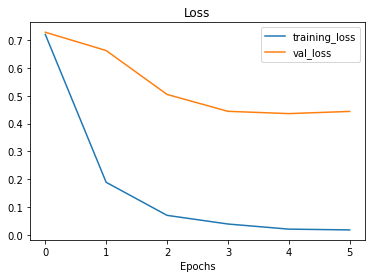

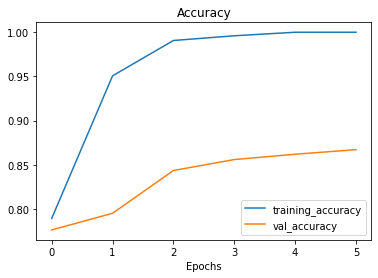

In [ ]:
# Plot loss curves
plot_loss_curves(history_2)

## 3. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [ ]:
# Load weights
model.load_weights("food_vision_check_point/")

In [ ]:
# Refreeze 30 layers
base_model.trainable=True

for layer in base_model.layers[:-30]:
  layer.trainable = False

In [ ]:
# Recompling the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 1,508,970
Non-trainable params: 2,553,411
_________________________________________________________________


In [ ]:
# Fit the model
fine_tune_epochs = initial_epochs + 10

history_3 = model.fit(train_data,
                      epochs=fine_tune_epochs,
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      initial_epoch=history_1.epoch[-1])

Epoch 5/15
24/24 [==============================] - 23s 659ms/step - loss: 0.0367 - accuracy: 0.9893 - val_loss: 0.6683 - val_accuracy: 0.8292
Epoch 6/15
24/24 [==============================] - 14s 588ms/step - loss: 0.0374 - accuracy: 0.9907 - val_loss: 0.7220 - val_accuracy: 0.8276
Epoch 7/15
24/24 [==============================] - 14s 587ms/step - loss: 0.0602 - accuracy: 0.9880 - val_loss: 0.8310 - val_accuracy: 0.8324
Epoch 8/15
24/24 [==============================] - 14s 594ms/step - loss: 0.0532 - accuracy: 0.9853 - val_loss: 0.7538 - val_accuracy: 0.8408
Epoch 9/15
24/24 [==============================] - 14s 590ms/step - loss: 0.0385 - accuracy: 0.9907 - val_loss: 0.8374 - val_accuracy: 0.8340
Epoch 10/15
24/24 [==============================] - 14s 588ms/step - loss: 0.0287 - accuracy: 0.9920 - val_loss: 0.7295 - val_accuracy: 0.8452
Epoch 11/15
24/24 [==============================] - 14s 587ms/step - loss: 0.0184 - accuracy: 0.9947 - val_loss: 0.6904 - val_accuracy: 0.84

# 4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [ ]:
# Creating function

def dataset_visualizer(dataset, model, class_names):
  image_batch, label_batch = dataset.as_numpy_iterator().next()
  batch_prob = [model.predict(tf.expand_dims(img, axis=0)) for img in image_batch]
  batch_preds = [class_names[np.argmax(prob)] for prob in batch_prob]

  plt.figure(figsize=(10, 10))
  for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    if class_names[np.argmax(label_batch[i])] == batch_preds[i]:
      title_color="g"
    else:
      title_color="r"
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f"Predict: {batch_preds[i]} , Prob: {batch_prob[i].max():.2f}", c=title_color)
    plt.axis(False)            

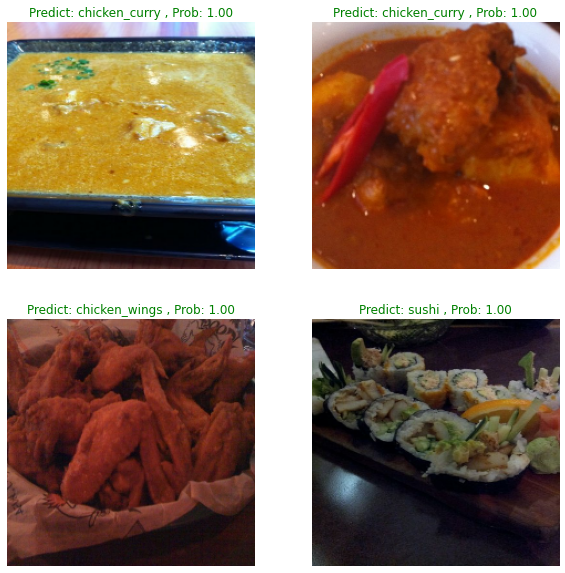

In [ ]:
dataset_visualizer(test_data, model, train_data.class_names)